<img src="../img/logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales
# Semana 4:
#### Nicolas Pereyra
---
## Consigna:

### TS4: Simulación de un ADC (cuantización y alias) parte 2/2

En esta tarea semanal retomamos la consigna de la tarea anterior, donde simulamos el bloque de cuantización de un ADC de B bits en un rango de  ±VF Volts. Ahora vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a fs Hertz.

Para ello se simulará el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los parámetros a ajustar de la senoidal:

- Frecuencia $f_{o}$ arbitraria, por ejemplo $f_{0}=\frac{f_{S}}{N}=\Delta f$
- Energía normalizada, es decir energía (o varianza) unitaria

Con respecto a los parámetros de la secuencia de ruido, diremos que:

+ Será de carácter aditivo, es decir la señal que entra al ADC será $s_{R}=s+n$. Siendo $n$ la secuencia que simula la interferencia, y $s$ la senoidal descrita anteriormente.
+ La potencia del ruido será $P_{n}=k_{n}.P_{q}$ siendo el factor $k$ una escala para la potencia del ruido de cuantización $P_{q}=\frac{q²}{12}$.
+ Finalmente, $n$ será incorrelado y Gaussiano.

El ADC que deseamos simular trabajará a una frecuencia de muestreo $f_{S}=1000$ Hz y tendrá un rango analógico de $±VF=2$ Volts.

Se pide:

    a) Generar el siguiente resultado producto de la experimentación. B = 4 bits, kn=1.
    b) Analizar para una de las siguientes configuraciones B = ̣{4, 8 y 16} bits, kn={1/10,1,10}. Discutir los resultados respecto a lo obtenido en a).

Bonus:

    💎 Encontrar la relación entre la cantidad de B bits del ADC y el SNR de la señal digitalizada. (Ver Holton. DSP Principles and App. 6.7 ADC Quantization pag. 387 )
    🤯 Simular el efecto del aliasing junto con el muestreo.

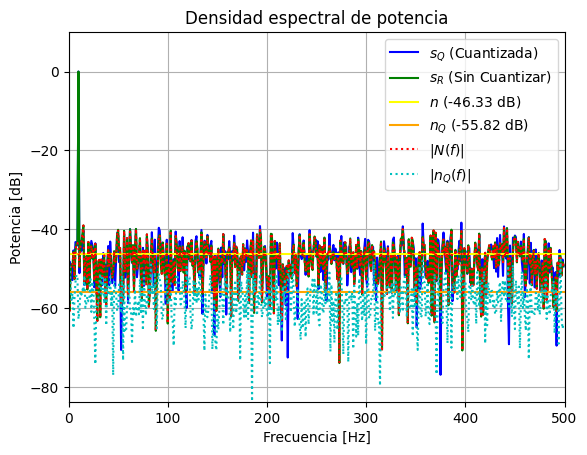

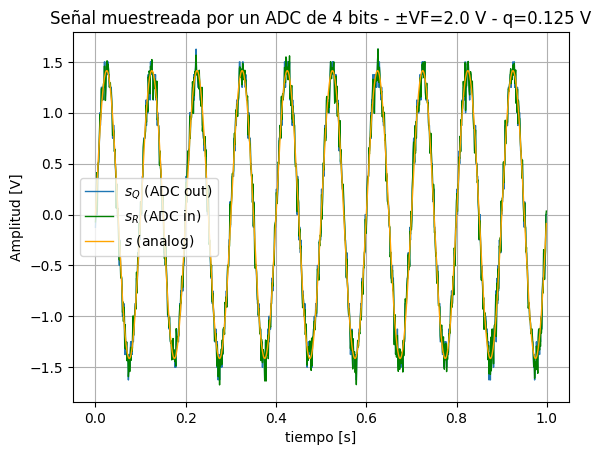

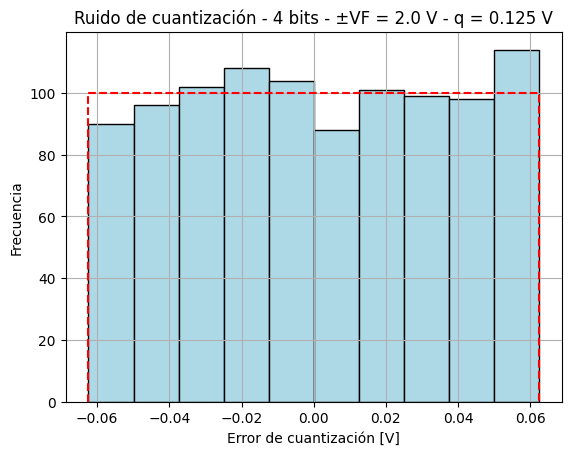

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# Datos generales
fs = 1000.0
N = 1000

# ADC
B = 4
Vf = 2
q = Vf / 2**B

# Ruido
kn = 10
Pq = q**2 / 12
Pn = kn * Pq

# Ruido gaussiano
n = np.random.normal(0, np.sqrt(Pn), size=N)  # Ruido analógico de la señal

# Tiempo
ts = 1 / fs
tt = np.arange(0, N) * ts

# Señal analógica
f0 = fs / N * 10                  # 10 Hz
omega0 = 2 * np.pi * f0
s = np.sqrt(2) * np.sin(omega0 * tt)
sr = s + n                            # Señal sin cuantizar pero con ruido
srq = q * np.floor(sr / q + 0.5)      # Señal cuantizada
nq = srq - sr                         # Error de cuantización

# FFTs
ff = np.fft.fftfreq(N, d=ts)
ft_Srq = np.fft.fft(srq) / N
ft_SR = np.fft.fft(sr) / N
ft_Nq = np.fft.fft(nq) / N
ft_S = np.fft.fft(s) / N
ft_N = np.fft.fft(n) / N

# Cálculo de potencias promedio
P_s = np.mean(np.abs(ft_S)**2)
P_n = np.mean(np.abs(ft_N)**2)
P_nq = np.mean(np.abs(ft_Nq)**2)

# Acoto a [0, fs/2]
bfrec = (ff >= 0) & (ff <= fs/2)
ff_valid = ff[bfrec]

# Convertir potencias a dB
n_valor_db = 10 * np.log10(2 * P_n)
nq_valor_db = 10 * np.log10(2 * P_nq)
s_valor_db = 10 * np.log10(2 * P_s)

# Señales a graficar con estilo de línea
curvas = [
    ('$s_Q$ (Cuantizada)', ff_valid, 10 * np.log10(2 * np.abs(ft_Srq[bfrec])**2), 'b', '-'),
    ('$s_R$ (Sin Cuantizar)', ff_valid, 10 * np.log10(2 * np.abs(ft_SR[bfrec])**2), 'g', '-'),
    ('$n$ ({:.2f} dB)'.format(n_valor_db), ff_valid, [n_valor_db]*len(ff_valid), 'yellow', '-'),     # Línea horizontal del ruido analógico
    ('$n_Q$ ({:.2f} dB)'.format(nq_valor_db), ff_valid, [nq_valor_db]*len(ff_valid), 'orange', '-'),  # Línea horizontal del error de cuantización
    ('$|N(f)|$', ff_valid, 10 * np.log10(2 * np.abs(ft_N[bfrec])**2), 'r', ':'),                 # Curva del ruido analógico
    ('$|n_Q(f)|$', ff_valid, 10 * np.log10(2 * np.abs(ft_Nq[bfrec])**2), 'c', ':'),              # Curva del ruido de cuantización
]


# Graficar densidad espectral de potencia
plt.figure(1)
for titulo, frec, pot, color, estilo in curvas:
    plt.plot(frec, pot, label=titulo, color=color, linestyle=estilo)

plt.title('Densidad espectral de potencia')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.grid(True)
plt.xlim([0, fs / 2])
plt.ylim((1.5*np.min(10*np.log10(2*np.array([P_nq, P_n, P_s]))), 10))
plt.legend()

# Gráfico temporal
plt.figure(2)
plt.plot(tt, srq, lw=1, linestyle='-', label='$s_Q$ (ADC out)')
plt.plot(tt, sr, lw=1, linestyle='-', color='green', label='$s_R$ (ADC in)')
plt.plot(tt, s, lw=1, color='orange', linestyle='-', label='$s$ (analog)')

plt.title(f'Señal muestreada por un ADC de {B} bits - ±VF={Vf:.1f} V - q={q:.3f} V')
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.legend()
plt.grid(True)

# Histograma del ruido de cuantización
plt.figure(3)
bins = 10
plt.hist(nq, bins=bins, color='lightblue', edgecolor='black')
plt.plot([-q/2, -q/2, q/2, q/2], [0, N/bins, N/bins, 0], '--r')
plt.title(f'Ruido de cuantización - {B} bits - ±VF = {Vf:.1f} V - q = {q:.3f} V')
plt.xlabel('Error de cuantización [V]')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.show()

### Conclucion:
A partir de los gráficos obtenidos, podemos extraer varias observaciones relevantes. Comenzando por el histograma del error de cuantización, se aprecia una alta coincidencia con la plantilla teórica de distribución uniforme. Esto confirma que el ruido de cuantización presenta efectivamente una distribución uniforme, como se espera en un ADC ideal.

En cuanto al espectro de potencia, se observa claramente la diferencia entre la señal cuantizada y la señal original sin cuantizar. Además, se verifica que el ruido analógico tiene una potencia aproximadamente $k$ veces mayor que la del ruido de cuantización, lo cual concuerda con el parámetro configurado ($k = 10$ en este caso).

Por otro lado, al analizar la distribución espectral del ruido, se nota que la contribución del ruido total está dominada por el ruido analógico. Esto sugiere que, en este caso, el ADC tiene una resolución superior a la que el sistema realmente necesita, o bien que el sistema analógico introduce un nivel de ruido mayor que el error de cuantización. En ambos casos, se concluye que el desempeño del ADC no es el factor limitante en la calidad final de la señal digitalizada.

---
### B)

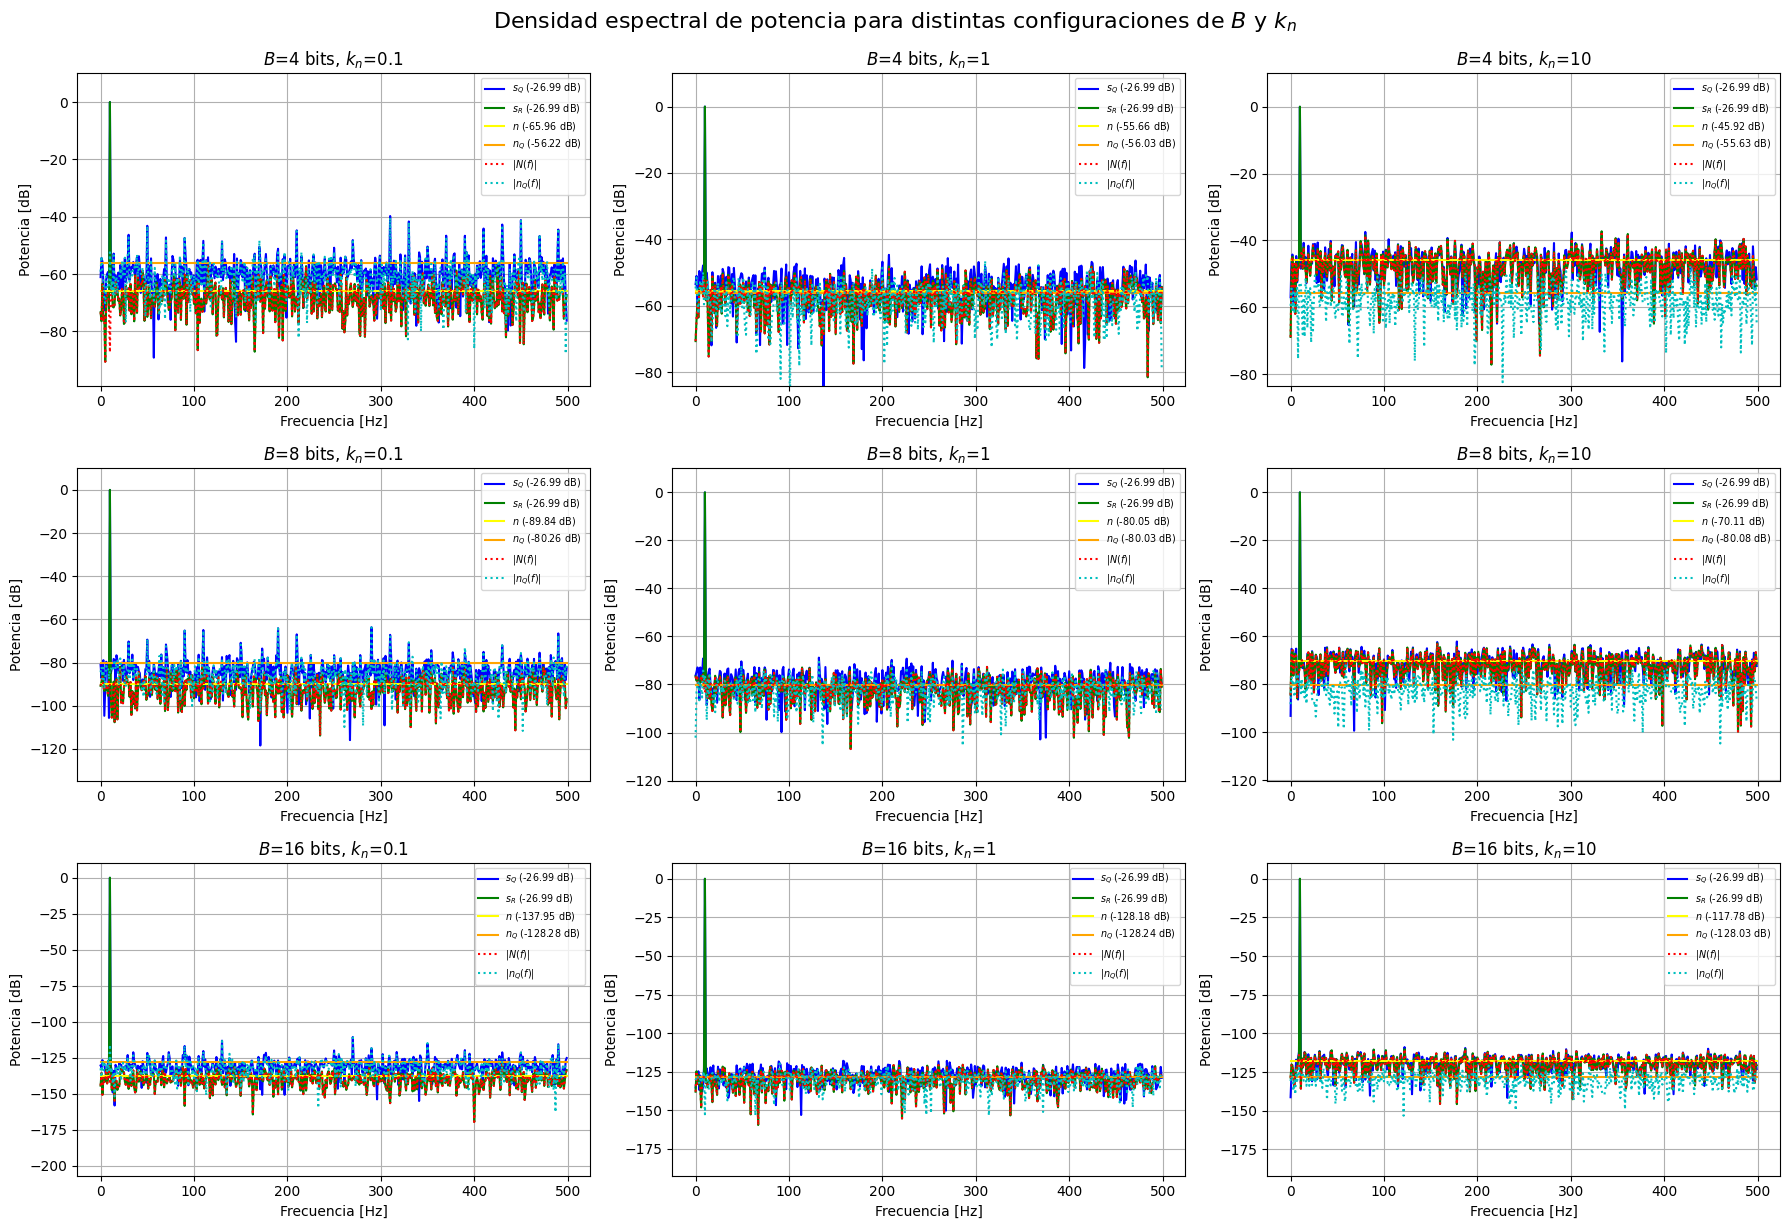

In [27]:
# Parámetros a evaluar
B_list = [4, 8, 16]
kn_list = [0.1, 1, 10]

# Figura para espectros
plt.figure(figsize=(18, 12))
plot_idx = 1

# Colores y estilos fijos para todas las curvas
colores = {
    's_Q': ('b', '-'),
    's_R': ('g', '-'),
    'n': ('yellow', '-'),
    'n_Q': ('orange', '-'),
    '|N(f)|': ('r', ':'),
    '|n_Q(f)|': ('c', ':')
}

for B in B_list:
    q = Vf / 2**B
    Pq = q**2 / 12
    for kn in kn_list:
        Pn = kn * Pq

        # Ruido analógico
        n = np.random.normal(0, np.sqrt(Pn), size=N)
        sr = s + n
        srq = q * np.floor(sr / q + 0.5)
        nq = srq - sr

        # FFTs
        ft_Srq = np.fft.fft(srq) / N
        ft_SR = np.fft.fft(sr) / N
        ft_Nq = np.fft.fft(nq) / N
        ft_N = np.fft.fft(n) / N

        # Potencias promedio
        P_s = np.mean(np.abs(ft_S)**2)
        P_n = np.mean(np.abs(ft_N)**2)
        P_nq = np.mean(np.abs(ft_Nq)**2)

        s_valor_db = 10 * np.log10(2 * P_s)
        n_valor_db = 10 * np.log10(2 * P_n)
        nq_valor_db = 10 * np.log10(2 * P_nq)

        # Subplot para esta configuración
        plt.subplot(len(B_list), len(kn_list), plot_idx)

        # Curvas con sus etiquetas y valores dB
        curvas = [
            (f'$s_Q$ ({s_valor_db:.2f} dB)', ff_valid, 10 * np.log10(2 * np.abs(ft_Srq[bfrec])**2), 's_Q'),
            (f'$s_R$ ({s_valor_db:.2f} dB)', ff_valid, 10 * np.log10(2 * np.abs(ft_SR[bfrec])**2), 's_R'),
            (f'$n$ ({n_valor_db:.2f} dB)', ff_valid, [n_valor_db]*len(ff_valid), 'n'),
            (f'$n_Q$ ({nq_valor_db:.2f} dB)', ff_valid, [nq_valor_db]*len(ff_valid), 'n_Q'),
            (f'$|N(f)|$', ff_valid, 10 * np.log10(2 * np.abs(ft_N[bfrec])**2), '|N(f)|'),
            (f'$|n_Q(f)|$', ff_valid, 10 * np.log10(2 * np.abs(ft_Nq[bfrec])**2), '|n_Q(f)|'),
        ]

        for titulo, frec, pot, key in curvas:
            color, estilo = colores[key]
            plt.plot(frec, pot, label=titulo, color=color, linestyle=estilo)

        plt.title(f'$B$={B} bits, $k_n$={kn}')
        plt.xlabel('Frecuencia [Hz]')
        plt.ylabel('Potencia [dB]')
        plt.grid(True)
        plt.ylim((1.5*np.min(10*np.log10(2*np.array([P_nq, P_n, P_s]))), 10))
        plt.legend(fontsize='x-small')
        plot_idx += 1

# Ajustar todo
plt.tight_layout()
plt.suptitle('Densidad espectral de potencia para distintas configuraciones de $B$ y $k_n$', fontsize=16, y=1.02)
plt.show()


Para este punto se optó por graficar únicamente los espectros de potencia de cada configuración, ya que el histograma del error de cuantización presenta un comportamiento muy similar en todos los casos y el gráfico temporal no aporta información relevante para el análisis espectral.

Al observar los resultados, se aprecia una reducción notable del piso de ruido al aumentar la cantidad de bits del ADC. Esto era esperable, ya que tanto el ruido de cuantización como el ruido analógico están relacionados con la resolución del convertidor: el primero de forma directa y el segundo de manera forzada en el código mediante el parámetro $k$.

En la tercera columna (correspondiente a $k=10$), puede verse con claridad el efecto discutido en el punto $a)$ para distintas resoluciones: el ruido analógico domina completamente al de cuantización cuando es mucho mayor.

Por el contrario, en la primera columna (con $k=0,1$), se observa el caso inverso: el ruido de cuantización es mayor que el ruido analógico, lo que genera un escenario en el que la resolución del ADC limita significativamente la calidad de la señal digitalizada.

### Bonus:
Holton nos demuestre en libro una expresion que nos permite calcular de manera rapida y preciza la SNR de una señal con un gran ruido de cuantizacion despeciando el ruido analogico.

<img src="../img/holton_snr.png" /> 


Aunque la formula general sea la superior normalmente se utiliza la siguiente expresion cual asume que la señal es una senoidal de amplidtud maxima.
$SNR_{q} = 6.02 * B + 1.76$

